In [1]:
## Imports
from pathlib import Path
import sys

sys.path.append("..")

# import shutil
import warnings
import opendatasets as od
from typing import Optional, Callable, Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# import torchvision
from torch.utils.data import Subset, random_split
from torchvision.datasets.vision import VisionDataset
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader
from utils.coba_dataset import COBA, COBA_Split

import copy
import pickle
import numpy as np
import pandas as pd
import torch

from utils.options import args_parser
from utils.train_utils import get_data, get_model
from models.Update import LocalUpdate
from models.test import test_img
import os

from utils.options import get_logger
from logging import Logger

In [2]:
## Simulate the args like in the `main_*.py` files
class ARGS:
    # federated arguments
    # epochs:int = 1000         # rounds of training
    epochs: int = 10  # rounds of training
    train_test_same: int = 0  # use same testing for
    num_users: int = 100  # number of users: K
    shard_per_user: int = 2  # classes per user
    frac: float = 0.1  # the fraction of clients: C
    local_ep: int = 1  # the number of local epochs: E
    local_bs: int = 10  # local batch size: B
    bs: int = 128  # test batch size
    lr: float = 0.01  # learning rate
    # results_save:str = "run1"
    momentum: float = 0.5  # SGD momentum (default: 0.5)
    # gpu:int = 0
    split: str = "user"  # train-test split type, user or sample
    # grad_norm:str           # use_gradnorm_avging
    local_ep_pretrain: int = 0  # the number of pretrain local ep
    lr_decay: float = 1.0  # learning rate decay per round

    # model arguments
    model: str = "cnn"  # model name
    kernel_num: int = 9  # number of each kind of kernel
    kernel_sizes: str = "3,4,5"  # comma-separated kernel size to use for convolution
    norm: str = "batch_norm"  # batch_norm, layer_norm, or None
    num_filters: int = 32  # number of filters for conv nets
    max_pool: str = True  # whether use max pooling rather than strided convolutions
    num_layers_keep: int = 1  # number layers to keep

    # other arguments
    dataset: str = "coba"  # name of dataset
    log_level: str = "info"  # level of logger
    iid: bool = True  # "store_true" #whether iid or not
    num_classes: int = 14  # number of classes
    num_channels: int = 3  # number of channels of images RGB
    gpu: int = 0  # GPU ID, -1 for CPU
    stopping_rounds: int = 10  # rounds of early stopping
    verbose: bool = True  # "store_true"
    print_freq: int = 100  # print loss frequency during training
    seed: int = 1  # random seed (default:1)
    test_freq: int = 1  # how often to test on val set
    load_fed: str = ""  # define pretrained federated model path
    results_save: str = "run1"  # define fed results save folder
    start_saving: int = 0  # when to start saving models


args = ARGS()

args.device = torch.device(
    "cuda:{}".format(args.gpu)
    if torch.cuda.is_available() and args.gpu != -1
    else "cpu"
)

args.num_users, args.device

(100, device(type='cuda', index=0))

In [3]:
## Initialize CobaDataset
coba_dataset: COBA = COBA(root="../data/coba", download=True)

In [4]:
## Create training and testing data -- method 1
train_size = int(0.8 * len(coba_dataset))
test_size = len(coba_dataset) - train_size
train_dataset, test_dataset = random_split(
    dataset=coba_dataset, lengths=[train_size, test_size]
)

In [5]:
len(train_dataset.indices)
# label.argmax()
# label_encodings[label.argmax().item()]
# print(f"Label: {label_encodings[label.argmax().item()]}")
# plt.imshow(img)

7046

Label: dog


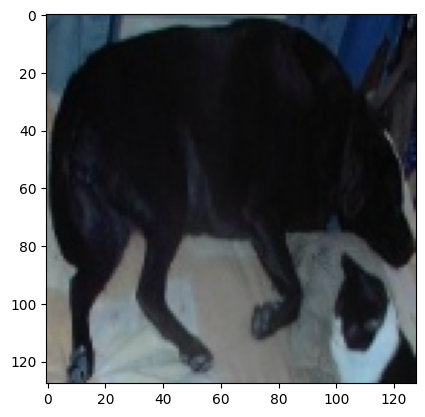

In [6]:
## Plot random train sample
example_image = coba_dataset[np.random.choice(train_dataset.indices, 1).item()]
img, label = example_image
label_encodings = train_dataset.dataset.class_to_idx

print(f"Label: {label_encodings[label.argmax().item()]}")
plt.imshow(img)

In [7]:
## The random split works!
dups = 0
for index in test_dataset.indices:
    if index in train_dataset.indices:
        dups += 1
print(dups)

0


In [8]:
from utils.sampling import iid

In [9]:
dict_users_train = iid(dataset=train_dataset.dataset, args=args)
for user, d in dict_users_train.items():
    print(f"user:{user}\t\t len:{len(d)}")

user:0		 len:88
user:1		 len:88
user:2		 len:88
user:3		 len:88
user:4		 len:88
user:5		 len:88
user:6		 len:88
user:7		 len:88
user:8		 len:88
user:9		 len:88
user:10		 len:88
user:11		 len:88
user:12		 len:88
user:13		 len:88
user:14		 len:88
user:15		 len:88
user:16		 len:88
user:17		 len:88
user:18		 len:88
user:19		 len:88
user:20		 len:88
user:21		 len:88
user:22		 len:88
user:23		 len:88
user:24		 len:88
user:25		 len:88
user:26		 len:88
user:27		 len:88
user:28		 len:88
user:29		 len:88
user:30		 len:88
user:31		 len:88
user:32		 len:88
user:33		 len:88
user:34		 len:88
user:35		 len:88
user:36		 len:88
user:37		 len:88
user:38		 len:88
user:39		 len:88
user:40		 len:88
user:41		 len:88
user:42		 len:88
user:43		 len:88
user:44		 len:88
user:45		 len:88
user:46		 len:88
user:47		 len:88
user:48		 len:88
user:49		 len:88
user:50		 len:88
user:51		 len:88
user:52		 len:88
user:53		 len:88
user:54		 len:88
user:55		 len:88
user:56		 len:88
user:57		 len:88
user:58		 len:88
user:59

In [10]:
## Try noniid example
import random
from utils.sampling import noniid

In [11]:
dict_users_train, rand_set_all = noniid(dataset=train_dataset.dataset, args=args)
for user, d in dict_users_train.items():
    print(f"user:{user}\t\t len:{len(d)}")

[2024-01-26 15:37:21,704] sampling.py :: WARNING  :: ValueError: cannot reshape array of size 196 into shape (100,newaxis). Attempting to reshape...
[2024-01-26 15:37:21,704] sampling.py :: INFO     :: New rand_set_all.shape: (98, 2)


user:0		 len:271
user:1		 len:271
user:2		 len:94
user:3		 len:72
user:4		 len:119
user:5		 len:38
user:6		 len:40
user:7		 len:27
user:8		 len:88
user:9		 len:36
user:10		 len:65
user:11		 len:48
user:12		 len:87
user:13		 len:93
user:14		 len:70
user:15		 len:65
user:16		 len:61
user:17		 len:40
user:18		 len:87
user:19		 len:42
user:20		 len:116
user:21		 len:66
user:22		 len:65
user:23		 len:63
user:24		 len:72
user:25		 len:62
user:26		 len:88
user:27		 len:65
user:28		 len:115
user:29		 len:115
user:30		 len:40
user:31		 len:96
user:32		 len:63
user:33		 len:63
user:34		 len:269
user:35		 len:48
user:36		 len:214
user:37		 len:96
user:38		 len:58
user:39		 len:92
user:40		 len:70
user:41		 len:65
user:42		 len:41
user:43		 len:93
user:44		 len:125
user:45		 len:95
user:46		 len:38
user:47		 len:48
user:48		 len:73
user:49		 len:42
user:50		 len:48
user:51		 len:59
user:52		 len:115
user:53		 len:63
user:54		 len:210
user:55		 len:39
user:56		 len:56
user:57		 len:97
user:58		 len

In [12]:
args.num_users

98

In [13]:
coba_dataset.class_to_idx

{0: 'airplane',
 1: 'ambulance',
 2: 'briefcase',
 3: 'cannon',
 4: 'car',
 5: 'civilian',
 6: 'dagger',
 7: 'dog',
 8: 'handgun',
 9: 'missilerocket',
 10: 'rifle',
 11: 'soldier',
 12: 'tank',
 13: 'truck'}

In [14]:
args.device = torch.device(
    "cuda:{}".format(args.gpu)
    if torch.cuda.is_available() and args.gpu != -1
    else "cpu"
)
args.device

device(type='cuda', index=0)

In [15]:
def main_loop():
    filename: str = "iobt_coba_data_viewer"
    logger: Logger = get_logger(args=args, filename=filename)

    logger.log(level=logger.level, msg=f"Log level: {args.log_level.upper()}")

    args.device = torch.device(
        f"cuda:{args.gpu}" if torch.cuda.is_available() and args.gpu != -1 else "cpu"
    )

    dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)

    logger.debug("%s dataset loaded", args.dataset.upper())

    base_dir: Path = Path(
        "save",
        args.dataset,
        f"{args.model}_iid{args.iid}_num{args.num_users}_C{args.frac}_le{args.local_ep}",
        f"shard{args.shard_per_user}",
    )

    run_num: int = int(args.results_save[-1])

    for file in base_dir.glob(pattern="*"):
        if args.results_save[:-1] in file.as_posix():
            run_num += 1
        else:
            break

    args.results_save = f"{args.results_save[:-1]}{run_num}"

    base_dir = Path(base_dir, args.results_save)

    logger.info("Base save directory: %s", base_dir)

    if not Path(base_dir, "fed").exists():
        Path(base_dir, "fed").mkdir(exist_ok=True, parents=True)

    dict_save_path: Path = Path(base_dir, "dict_users.pkl")
    with open(dict_save_path, "wb") as handle:
        pickle.dump((dict_users_train, dict_users_test), handle)

    # build model
    logger.debug("Building Model")
    net_glob = get_model(args)
    logger.debug("Model built\n%s", net_glob)

    logger.debug("Setting model to training mode")
    net_glob.train()

    # training
    results_save_path: Path = Path(base_dir, "fed/results.csv")

    loss_train = []
    net_best = None
    best_loss = None
    best_acc = None
    best_epoch = None

    w_glob = None
    m = max(int(args.frac * args.num_users), 1)

    lr: float = args.lr
    results: list = []

    logger.debug("Starting training loop")
    # for _iter in range(args.epochs):
    for _iter in range(1):
        loss_locals = []
        # w_glob = None
        # m = max(int(args.frac * args.num_users), 1)
        idxs_users = np.random.choice(range(args.num_users), m, replace=False)
        logger.info("Round %3d, lr: %.3f, %s", _iter, lr, idxs_users)

        for idx in idxs_users:
            logger.debug("User %i local training", idx)
            local = LocalUpdate(
                args=args, dataset=dataset_train, idxs=dict_users_train[idx]
            )
            logger.debug("\tcreating net_local")
            net_local = copy.deepcopy(net_glob)
            logger.debug("\tnet_local created")

            logger.debug("\ttraining to get w_local and loss")
            w_local, loss = local.train(net=net_local.to(args.device))
            logger.debug("\ttraining completed")

            logger.debug("\tadding loss to loss_locals")
            loss_locals.append(copy.deepcopy(loss))

            if w_glob is None:
                logger.debug("\tcreated w_glob (during User %i)", idx)
                w_glob = copy.deepcopy(w_local)
                # for k, tensor in w_glob.items():
                #         # w_glob[k] = tensor.detach().cpu()
                #         w_glob[k] = tensor.cpu()
            else:
                logger.debug("\tadding w_local[k] to each key k in w_glob[k]")
                for k in w_glob.keys():
                    # w_glob[k] += w_local[k].to("cpu")
                    w_glob[k] += w_local[k]

        logger.debug("Modifying lr")
        lr *= args.lr_decay

        # update global weights
        logger.debug("Updating global weights")
        for k in w_glob.keys():
            w_glob[k] = torch.div(w_glob[k], m)

        # copy weight to net_glob
        logger.debug("Copying weights")
        net_glob.load_state_dict(w_glob)

        # print loss
        logger.debug("Calculating Loss")
        loss_avg = sum(loss_locals) / len(loss_locals)
        loss_train.append(loss_avg)

        if (_iter + 1) % args.test_freq == 0:
            logger.debug("Evaluating net_glob")
            net_glob.eval()

            logger.debug("Calculating acc_test and loss_test")
            # acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test, loss_test, f1_test, precision_test, recall_test = test_img(
                net_glob, dataset_test, args
            )
            logger.info(
                # "\tRound %3d, Avg loss %.3f, Test loss %.6f, Test accuracy: %.2f",
                "\tAvg loss %.3f, Test loss %.6f, Test accuracy: %.2f",
                # _iter,
                loss_avg,
                loss_test,
                acc_test,
            )

            if best_acc is None or acc_test > best_acc:
                net_best = copy.deepcopy(net_glob)
                best_acc = acc_test
                best_epoch = _iter

            # if (iter + 1) > args.start_saving:
            #     model_save_path = os.path.join(base_dir, 'fed/model_{}.pt'.format(_iter + 1))
            #     torch.save(net_glob.state_dict(), model_save_path)

            results.append(np.array([_iter, loss_avg, loss_test, acc_test, best_acc]))
            final_results = np.array(results)
            final_results = pd.DataFrame(
                final_results,
                columns=["epoch", "loss_avg", "loss_test", "acc_test", "best_acc"],
            )
            final_results.to_csv(results_save_path, index=False)

        if (_iter + 1) % 50 == 0:
            best_save_path: Path = Path(base_dir, f"fed/best_{_iter+1}.pt")
            model_save_path: Path = Path(base_dir, f"fed/model_{_iter+1}.pt")

            if args.device.type != "cpu":
                torch.save(
                    net_best.to(torch.device("cpu")).state_dict(), best_save_path
                )
                torch.save(
                    net_glob.to(torch.device("cpu")).state_dict(), model_save_path
                )
            else:
                torch.save(net_best.state_dict(), best_save_path)
                torch.save(net_glob.state_dict(), model_save_path)

    logger.info("Best model, iter: %i, acc: %f", best_epoch, best_acc)

In [16]:
main_loop()

[2024-01-26 15:37:21,757] 3574336954.py :: INFO     :: Log level: INFO


100%|████████████████████████████████████████████████████| 478M/478M [00:09<00:00, 55.2MB/s]


[2024-01-26 15:37:45,942] 3574336954.py :: INFO     :: Base save directory: save/coba/cnn_iidTrue_num98_C0.1_le1/shard2/run1
[2024-01-26 15:37:46,862] 3574336954.py :: INFO     :: Round   0, lr: 0.010, [58 71 25 83 11 18  9 60 81]


CNNCoba(
  (layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=65536, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=14, bias=True)
    (7): LogSoftmax(dim=1)
  )
)


[2024-01-26 15:37:49,010] test.py :: INFO     :: Test set: Avg loss: 2.5320, Accuracy: 2748/8808 (31.20%), F1: 0.1176, Precision: 0.0777, Recall: 0.2445
[2024-01-26 15:37:49,011] 3574336954.py :: INFO     :: 	Avg loss 3.031, Test loss 2.532012, Test accuracy: 31.20
[2024-01-26 15:37:49,023] 3574336954.py :: INFO     :: Best model, iter: 0, acc: 31.198910


In [17]:
# # Troubleshooting with GPU errors
# print("Device before")
# for k in w_glob.keys():
#     print(f"\t {w_glob[k].device}")

# w_glob = copy.deepcopy(w_local)

# for k,value in w_glob.items():
#     # w_glob[k] = value.detach().cpu()
#     w_glob[k] = value.cpu()

# print("Device after")
# for k in w_glob.keys():
#     print(f"\t {w_glob[k].device}")

In [18]:
## Troubleshooting with Shape errors
# image,label = coba_dataset[0]
# print(image.shape)
# image = image.permute(2,0,1)
# print(image.shape)

In [19]:
# imgs, labels = train_dataset.dataset[:]

In [20]:
# labels

In [21]:
# torch.tensor(list(map(torch.argmax,labels)))

In [22]:
# args.device

In [23]:
# args.device.type

In [24]:
# list(test_dataset.dataset.class_to_idx.keys())

In [25]:
trans_mnist = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

args.num_users = 100
args.num_classes = 10
args.dataset = "mnist"
args.model = "mlp"

dataset_train = datasets.MNIST(
    "data/mnist/", train=True, download=True, transform=trans_mnist
)
dataset_test = datasets.MNIST(
    "data/mnist/", train=False, download=True, transform=trans_mnist
)

dict_users_train, rand_set_all = noniid(dataset=dataset_train, args=args)
dict_users_test, rand_set_all = noniid(
    dataset=dataset_test,
    args=args,
    rand_set_all=rand_set_all,
)
main_loop()

100%|███████████████████████████████████████| 9912422/9912422 [00:00<00:00, 53926007.19it/s]


Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



100%|████████████████████████████████████████████| 28881/28881 [00:00<00:00, 6480617.05it/s]


Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



100%|███████████████████████████████████████| 1648877/1648877 [00:00<00:00, 17621093.15it/s]


Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



100%|█████████████████████████████████████████████| 4542/4542 [00:00<00:00, 31488477.30it/s]


Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



[2024-01-26 15:37:50,427] sampling.py :: INFO     :: New rand_set_all.shape: (100, 2)
[2024-01-26 15:37:50,427] sampling.py :: INFO     :: New rand_set_all.shape: (100, 2)
[2024-01-26 15:37:50,471] 3574336954.py :: INFO     :: Log level: INFO
[2024-01-26 15:37:50,471] 3574336954.py :: INFO     :: Log level: INFO
[2024-01-26 15:37:50,738] 3574336954.py :: INFO     :: Base save directory: save/mnist/mlp_iidTrue_num100_C0.1_le1/shard2/run1
[2024-01-26 15:37:50,738] 3574336954.py :: INFO     :: Base save directory: save/mnist/mlp_iidTrue_num100_C0.1_le1/shard2/run1
[2024-01-26 15:37:50,839] 3574336954.py :: INFO     :: Round   0, lr: 0.010, [44 96  1 35 26 11 38 82 87  3]
[2024-01-26 15:37:50,839] 3574336954.py :: INFO     :: Round   0, lr: 0.010, [44 96  1 35 26 11 38 82 87  3]


MLP(
  (layer_input): Linear(in_features=784, out_features=512, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_hidden1): Linear(in_features=512, out_features=256, bias=True)
  (layer_hidden2): Linear(in_features=256, out_features=256, bias=True)
  (layer_hidden3): Linear(in_features=256, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


[2024-01-26 15:37:54,177] test.py :: INFO     :: Test set: Avg loss: 2.3014, Accuracy: 1819/10000 (18.19%), F1: 0.0703, Precision: 0.0629, Recall: 0.1443
[2024-01-26 15:37:54,177] test.py :: INFO     :: Test set: Avg loss: 2.3014, Accuracy: 1819/10000 (18.19%), F1: 0.0703, Precision: 0.0629, Recall: 0.1443
[2024-01-26 15:37:54,179] 3574336954.py :: INFO     :: 	Avg loss 2.302, Test loss 2.301375, Test accuracy: 18.19
[2024-01-26 15:37:54,179] 3574336954.py :: INFO     :: 	Avg loss 2.302, Test loss 2.301375, Test accuracy: 18.19
[2024-01-26 15:37:54,183] 3574336954.py :: INFO     :: Best model, iter: 0, acc: 18.190000
[2024-01-26 15:37:54,183] 3574336954.py :: INFO     :: Best model, iter: 0, acc: 18.190000


In [26]:
trans_cifar10_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
trans_cifar10_val = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

args.num_users = 100
args.num_classes = 10
args.dataset = "cifar10"
args.model = "cnn"

dataset_train = datasets.CIFAR10(
    "data/cifar10/", train=True, download=True, transform=trans_cifar10_train
)
dataset_test = datasets.CIFAR10(
    "data/cifar10/", train=False, download=True, transform=trans_cifar10_val
)

dict_users_train, rand_set_all = noniid(dataset=dataset_train, args=args)
dict_users_test, rand_set_all = noniid(
    dataset=dataset_test,
    args=args,
    rand_set_all=rand_set_all,
)
main_loop()

100%|███████████████████████████████████| 170498071/170498071 [00:04<00:00, 39581241.46it/s]


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10/
Files already downloaded and verified


[2024-01-26 15:38:01,282] sampling.py :: INFO     :: New rand_set_all.shape: (100, 2)
[2024-01-26 15:38:01,282] sampling.py :: INFO     :: New rand_set_all.shape: (100, 2)
[2024-01-26 15:38:01,282] sampling.py :: INFO     :: New rand_set_all.shape: (100, 2)
[2024-01-26 15:38:01,282] sampling.py :: INFO     :: New rand_set_all.shape: (100, 2)
[2024-01-26 15:38:01,447] 3574336954.py :: INFO     :: Log level: INFO
[2024-01-26 15:38:01,447] 3574336954.py :: INFO     :: Log level: INFO
[2024-01-26 15:38:01,447] 3574336954.py :: INFO     :: Log level: INFO


Files already downloaded and verified
Files already downloaded and verified


[2024-01-26 15:38:02,705] 3574336954.py :: INFO     :: Base save directory: save/cifar10/cnn_iidTrue_num100_C0.1_le1/shard2/run1
[2024-01-26 15:38:02,705] 3574336954.py :: INFO     :: Base save directory: save/cifar10/cnn_iidTrue_num100_C0.1_le1/shard2/run1
[2024-01-26 15:38:02,705] 3574336954.py :: INFO     :: Base save directory: save/cifar10/cnn_iidTrue_num100_C0.1_le1/shard2/run1
[2024-01-26 15:38:02,791] 3574336954.py :: INFO     :: Round   0, lr: 0.010, [44 96  1 35 26 11 38 82 87  3]
[2024-01-26 15:38:02,791] 3574336954.py :: INFO     :: Round   0, lr: 0.010, [44 96  1 35 26 11 38 82 87  3]
[2024-01-26 15:38:02,791] 3574336954.py :: INFO     :: Round   0, lr: 0.010, [44 96  1 35 26 11 38 82 87  3]


CNNCifar(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


[2024-01-26 15:38:07,579] test.py :: INFO     :: Test set: Avg loss: 2.3042, Accuracy: 1008/10000 (10.08%), F1: 0.0172, Precision: 0.0180, Recall: 0.0788
[2024-01-26 15:38:07,579] test.py :: INFO     :: Test set: Avg loss: 2.3042, Accuracy: 1008/10000 (10.08%), F1: 0.0172, Precision: 0.0180, Recall: 0.0788
[2024-01-26 15:38:07,579] test.py :: INFO     :: Test set: Avg loss: 2.3042, Accuracy: 1008/10000 (10.08%), F1: 0.0172, Precision: 0.0180, Recall: 0.0788
[2024-01-26 15:38:07,582] 3574336954.py :: INFO     :: 	Avg loss 2.293, Test loss 2.304178, Test accuracy: 10.08
[2024-01-26 15:38:07,582] 3574336954.py :: INFO     :: 	Avg loss 2.293, Test loss 2.304178, Test accuracy: 10.08
[2024-01-26 15:38:07,582] 3574336954.py :: INFO     :: 	Avg loss 2.293, Test loss 2.304178, Test accuracy: 10.08
[2024-01-26 15:38:07,585] 3574336954.py :: INFO     :: Best model, iter: 0, acc: 10.080000
[2024-01-26 15:38:07,585] 3574336954.py :: INFO     :: Best model, iter: 0, acc: 10.080000
[2024-01-26 15:38

In [27]:
## Simulate the args like in the `main_*.py` files
class ARGS:
    # federated arguments
    # epochs:int = 1000         # rounds of training
    epochs: int = 10  # rounds of training
    train_test_same: int = 0  # use same testing for
    num_users: int = 100  # number of users: K
    shard_per_user: int = 2  # classes per user
    frac: float = 0.1  # the fraction of clients: C
    local_ep: int = 1  # the number of local epochs: E
    local_bs: int = 10  # local batch size: B
    bs: int = 128  # test batch size
    lr: float = 0.01  # learning rate
    # results_save:str = "run1"
    momentum: float = 0.5  # SGD momentum (default: 0.5)
    # gpu:int = 0
    split: str = "user"  # train-test split type, user or sample
    # grad_norm:str           # use_gradnorm_avging
    local_ep_pretrain: int = 0  # the number of pretrain local ep
    lr_decay: float = 1.0  # learning rate decay per round

    # model arguments
    model: str = "cnn"  # model name
    kernel_num: int = 9  # number of each kind of kernel
    kernel_sizes: str = "3,4,5"  # comma-separated kernel size to use for convolution
    norm: str = "batch_norm"  # batch_norm, layer_norm, or None
    num_filters: int = 32  # number of filters for conv nets
    max_pool: str = True  # whether use max pooling rather than strided convolutions
    num_layers_keep: int = 1  # number layers to keep

    # other arguments
    dataset: str = "coba"  # name of dataset
    log_level: str = "info"  # level of logger
    iid: bool = True  # "store_true" #whether iid or not
    num_classes: int = 14  # number of classes
    num_channels: int = 3  # number of channels of images RGB
    gpu: int = 0  # GPU ID, -1 for CPU
    stopping_rounds: int = 10  # rounds of early stopping
    verbose: bool = True  # "store_true"
    print_freq: int = 100  # print loss frequency during training
    seed: int = 1  # random seed (default:1)
    test_freq: int = 1  # how often to test on val set
    load_fed: str = ""  # define pretrained federated model path
    results_save: str = "run1"  # define fed results save folder
    start_saving: int = 0  # when to start saving models


args = ARGS()

args.device = torch.device(
    "cuda:{}".format(args.gpu)
    if torch.cuda.is_available() and args.gpu != -1
    else "cpu"
)

args.num_users, args.device

(100, device(type='cuda', index=0))

## Verify Train/Test data differences

In [28]:
coba_dataset: COBA = COBA(root="../data/coba", download=True)

In [29]:
# train_size: int = int(
#             0.8 * len(coba_dataset)
# )  # maybe TODO: make the percentage customizable (part of `args`)
# test_size: int = len(coba_dataset) - train_size
# dataset_train, dataset_test = random_split(
#     dataset=coba_dataset, lengths=[train_size, test_size]
# )

In [30]:
# dataset_train, dataset_test

In [31]:
# new_dataset_train = [(img,label) for img,label in dataset_train]
# len(new_dataset_train) == train_size

In [32]:
# d_train = COBA_Split(dataset=dataset_train)
# d_test = COBA_Split(dataset=dataset_test)

# len(d_train), len(d_test)

In [33]:
# # iid
# dict_users_train: Dict[int, set] = iid(
#                 dataset=d_train, args=args
# )
# dict_users_test: Dict[int, set] = iid(
#     dataset=d_test, args=args
# )
# for user,d in dict_users_train.items():
#     print(f"user:{user}\t\t len:{len(d)}")

In [34]:
# # noniid
# dict_users_train, rand_set_all = noniid(
#                 dataset=d_train, args=args
# )
# dict_users_test, rand_set_all = noniid(
#     dataset=d_test,
#     args=args,
#     rand_set_all=rand_set_all,
# )

In [35]:
# for user,d in dict_users_train.items():
#     print(f"user:{user}\t\t len:{len(d)}")

## Analyze Results

In [3]:
args.device = torch.device(
    "cuda:{}".format(args.gpu)
    if torch.cuda.is_available() and args.gpu != -1
    else "cpu"
)

dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)

model = get_model(args)

model_state_dict_path: str = Path(
    "../save",
    "coba_legacy",
    "cnn_iidFalse_num98_C0.3_le1",
    "shard2",
    "seed10_coba_fedavg_bestcase_run12",
    "fed",
    "model_1000.pt",
)

model.load_state_dict(
    torch.load(model_state_dict_path)
) if args.device.type != "cpu" else model.load_state_dict(
    torch.load(model_state_dict_path, map_location=torch.device("cpu"))
)

CNNCoba(
  (layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=65536, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=14, bias=True)
    (7): LogSoftmax(dim=1)
  )
)


<All keys matched successfully>

In [4]:
data_loader: DataLoader = DataLoader(dataset_test, batch_size=args.bs)
IS_USING_GPU: bool = args.gpu != -1 and args.device.type != "cpu"

probs: np.array = np.array([])
y_preds: np.array = np.array([])
y_trues: np.array = np.array([])
# coba_cms = []

for _, (data, target) in enumerate(data_loader):
    if args.gpu != -1 and args.device.type != "cpu":
        data, target = data.to(args.device), target.to(args.device)
    if args.dataset == "coba":
        data = data.permute(0, 3, 1, 2)

    log_probs: torch.Tensor = model(data)

    probs: np.array = (
        np.append(probs, log_probs.cpu().data.numpy())
        if IS_USING_GPU
        else np.append(probs, log_probs.data.numpy())
    )

    y_pred: torch.Tensor = (
        log_probs.cpu().data.max(1, keepdim=True)[1]
        if args.device.type != "cpu"
        else log_probs.data.max(1, keepdim=True)[1]
    )

    y_true: torch.Tensor = (
        torch.tensor(list(map(torch.argmax, target.data)), device="cpu").data.view_as(
            y_pred
        )
        if args.dataset == "coba"
        else target.to("cpu").data.view_as(y_pred)
    )

    # coba_cms.append(confusion_matrix(y_pred=y_pred,y_true=y_true))

    y_preds = np.append(y_preds, y_pred)
    y_trues = np.append(y_trues, y_true)

y_preds.shape == y_trues.shape

True

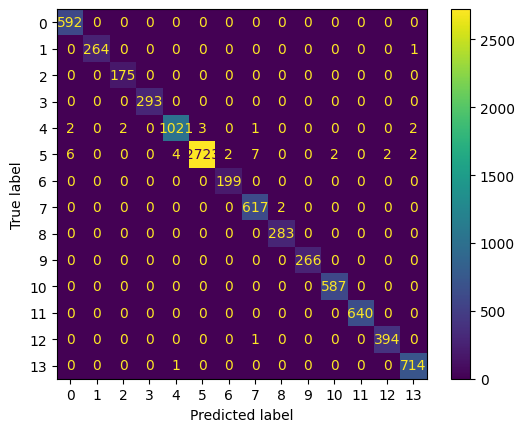

In [5]:
coba_cm = confusion_matrix(y_pred=y_preds, y_true=y_trues)
disp = ConfusionMatrixDisplay(confusion_matrix=coba_cm)
disp.plot()

In [6]:
# coba_cm_gen = (cm for cm in coba_cms)

In [ ]:
# disp = ConfusionMatrixDisplay(confusion_matrix=next(coba_cm_gen))
# disp.plot()

In [ ]:
# len(coba_cms)

In [ ]:
# for data, target in data_loader:
#     if args.dataset == "coba":
#         data = data.permute(0, 3, 1, 2) # rearranged to be: (batch size: N, color channels: C, height: H, width: W)

#     print(data.shape)
#     print(target.shape)
#     break

### Check class balance

In [7]:
coba_dataset: COBA = COBA(root="../data/coba", download=True)
all_targets: np.array = np.array(list(map(torch.argmax, coba_dataset.targets)))
all_targets.shape

(8808,)

In [8]:
target_class, target_occurences = np.unique(all_targets, return_counts=True)
# target_class, target_occurences

In [9]:
class_to_idx = coba_dataset.class_to_idx
for tc, occurence in zip(target_class, target_occurences):
    print(f"{class_to_idx[tc]:<13} ({tc:2}):\t{occurence}")

airplane      ( 0):	592
ambulance     ( 1):	265
briefcase     ( 2):	175
cannon        ( 3):	293
car           ( 4):	1031
civilian      ( 5):	2748
dagger        ( 6):	199
dog           ( 7):	619
handgun       ( 8):	283
missilerocket ( 9):	266
rifle         (10):	587
soldier       (11):	640
tank          (12):	395
truck         (13):	715


<Axes: xlabel='Occurences', ylabel='Classes'>

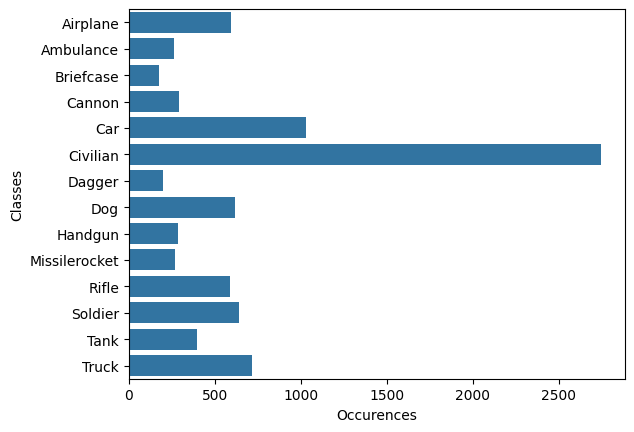

In [10]:
target_spread_df = pd.DataFrame(
    {
        "occurences": target_occurences,
        "classes": [class_to_idx[tc].title() for tc in target_class],
    }
)
plt.xlabel("Occurences")
plt.ylabel("Classes")
sns.barplot(data=target_spread_df, y="classes", x="occurences")

### Visualize Results

In [12]:
coba_results_path: str = Path(
    "../save",
    "coba_legacy",
    "cnn_iidFalse_num98_C0.3_le1",
    "shard2",
    "seed10_coba_fedavg_bestcase_run12",
    "fed",
    "results.csv",
)
coba_results_df: pd.DataFrame = pd.read_csv(coba_results_path, delimiter=",")

In [13]:
coba_results_df.describe()

,epoch,loss_avg,loss_test,acc_test,f1_test,precision_test,recall_test,best_acc
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,0.345473,0.863734,71.569267,0.553706,0.590254,0.560634,75.217711
std,288.819436,0.746869,0.831901,28.084318,0.230352,0.201873,0.219981,25.249273
min,0.000000,0.002734,0.011604,9.230245,0.025715,0.027763,0.072275,31.198910
25%,249.750000,0.024524,0.084107,41.885218,0.323443,0.416577,0.328247,46.821072
50%,499.500000,0.128729,0.520709,83.503633,0.653754,0.679631,0.654051,88.578565
75%,749.250000,0.572703,1.701580,98.098320,0.768840,0.770606,0.768481,98.776680
max,999.000000,20.007770,2.588678,99.920527,0.782749,0.782780,0.782758,99.920527


In [14]:
def graph_adjusted(col_name: str, filename: str, df: pd.DataFrame) -> None:
    adjusted_col = (
        df.groupby(np.arange(len(df)) // 10).mean()[col_name].values
    )  # averaged every 10 epochs
    epochs = np.arange(len(df) // 10) * 10
    sns.lineplot(x=epochs, y=adjusted_col).set(
        title=filename.split("_")[0].title(), xlabel="Epochs", ylabel="Value"
    )
    plt.savefig(filename)

### Best accuracy

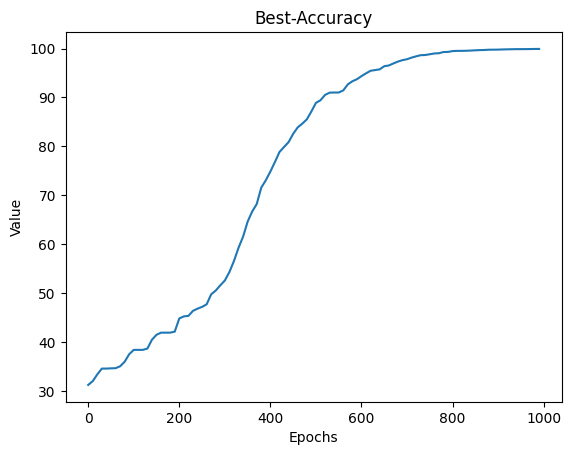

In [16]:
# best_accs:np.array = coba_results_df["best_acc"].values
# sns.lineplot(data=coba_results_df, x="epoch", y="best_acc")

graph_adjusted(
    col_name="best_acc", filename="best-Accuracy_example.png", df=coba_results_df
)

### Accuracy

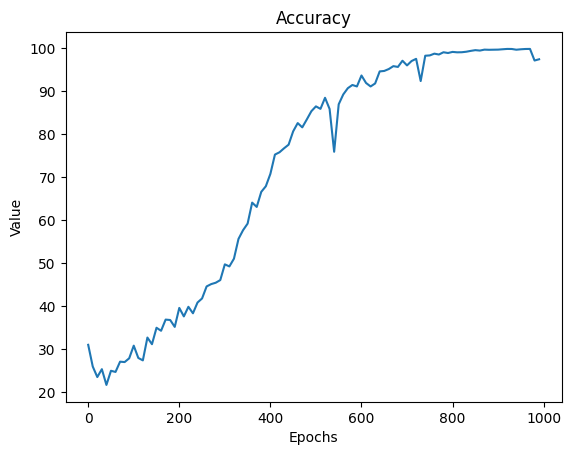

In [17]:
# epochs = coba_results_df["epoch"].values
# acc_test = coba_results_df["acc_test"].values

graph_adjusted(col_name="acc_test", filename="accuracy_example.png", df=coba_results_df)

### Loss (test)

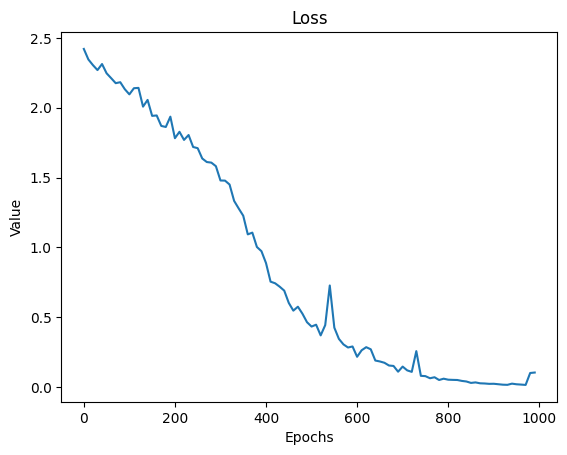

In [18]:
# epochs = coba_results_df["epoch"].values
# loss_test = coba_results_df["loss_test"].values

graph_adjusted(col_name="loss_test", filename="loss_example.png", df=coba_results_df)

### Loss (avg)

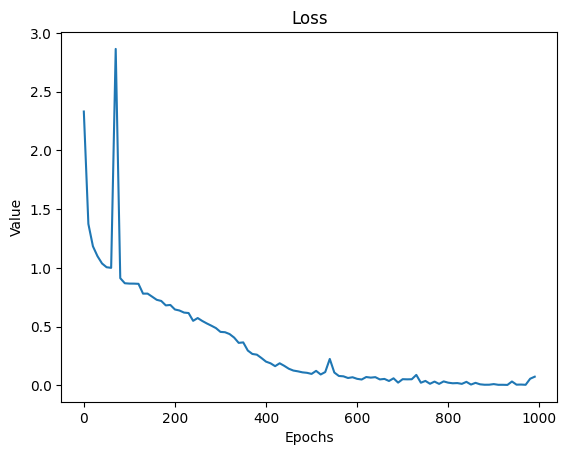

In [20]:
# epochs = coba_results_df["epoch"].values
# loss_avg = coba_results_df["loss_avg"].values

graph_adjusted(col_name="loss_avg", filename="loss_avg_example.png", df=coba_results_df)

### F1 Score

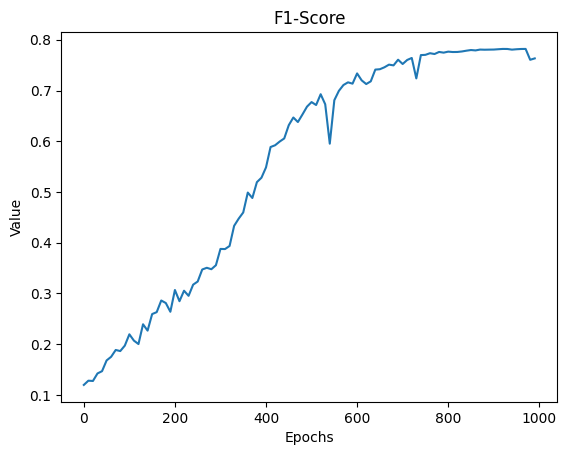

In [21]:
# epochs = coba_results_df["epoch"].values
# f1_test = coba_results_df["f1_test"].values

graph_adjusted(col_name="f1_test", filename="f1-Score_example.png", df=coba_results_df)

### Precision

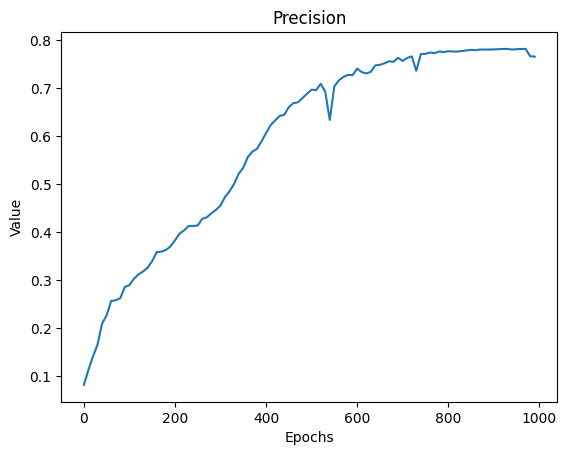

In [22]:
# epochs = coba_results_df["epoch"].values
# precision_test = coba_results_df["precision_test"].values

graph_adjusted(
    col_name="precision_test", filename="precision_example.png", df=coba_results_df
)

### Recall

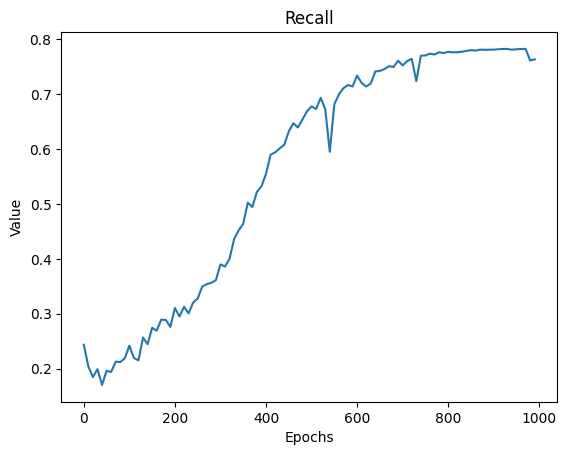

In [23]:
# epochs = coba_results_df["epoch"].values
# recall_test = coba_results_df["recall_test"].values

graph_adjusted(
    col_name="recall_test", filename="recall_example.png", df=coba_results_df
)